In [2]:
#Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import pandas as pd

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization

import seaborn as sns
from keras.applications.vgg16 import VGG16

import warnings
warnings.filterwarnings("ignore")

### Load Data


In [3]:
#Load Image path
import os
img_path = os.listdir(r"training")
print(img_path)

['Normal', 'Tuberculosis']


In [4]:
helper_function_file_path = 'helper_func.py'

In [5]:
import importlib.util

spec = importlib.util.spec_from_file_location("helper_func", helper_function_file_path)

In [6]:
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

In [7]:
#Generate Train Images and train labels
import helper_func as hf

train_images, train_labels = hf.generate_dataset(r"training/*",128)
#Generate test image and test labels
test_images, test_labels = hf.generate_dataset(r"testing/*", 128)

#Generate validationimage and validation labels
valid_images, valid_labels = hf.generate_dataset(r"validation/*",128)


Processing label: Normal
Processing label: Tuberculosis
Processing label: Normal
Processing label: Tuberculosis
Processing label: Normal
Processing label: Tuberculosis


In [8]:
train_labels

array(['Normal', 'Normal', 'Normal', ..., 'Tuberculosis', 'Tuberculosis',
       'Tuberculosis'], shape=(5600,), dtype='<U12')

##### Encode labels from text to integers.


In [9]:

from sklearn.preprocessing import LabelEncoder
import numpy as np

# Combine all labels
all_labels = np.concatenate([train_labels, test_labels, valid_labels])
le = LabelEncoder()
# Fit the LabelEncoder
le.fit(all_labels)

# Encode training, test, and validation labels
train_labels_encoded = le.transform(train_labels)
test_labels_encoded = le.transform(test_labels)
validation_labels_encoded = le.transform(valid_labels)

print(train_labels)


['Normal' 'Normal' 'Normal' ... 'Tuberculosis' 'Tuberculosis'
 'Tuberculosis']


In [10]:
train_labels_encoded

array([0, 0, 0, ..., 1, 1, 1], shape=(5600,))

##### Split data into test and train dataset


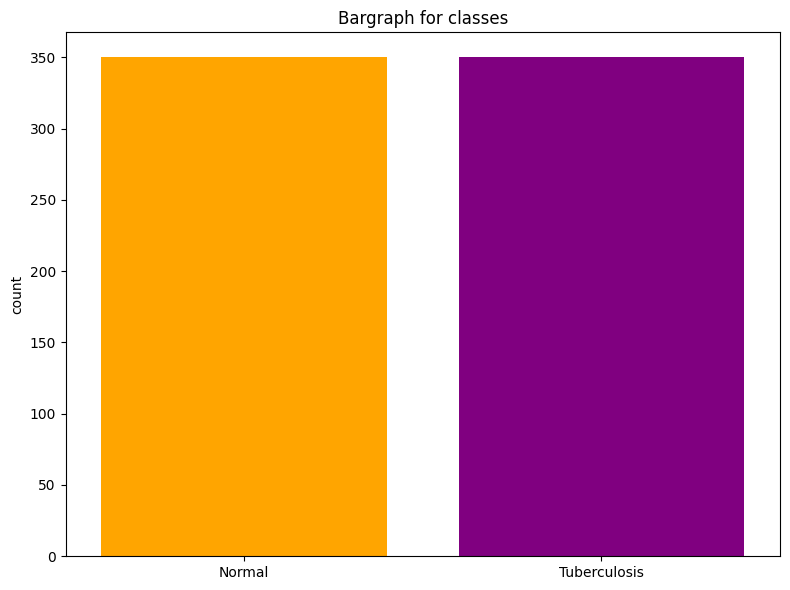

In [11]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded
x_valid, y_valid = valid_images, validation_labels_encoded

#Check for imbalance in target class
pd.DataFrame(train_labels).value_counts()

# fig, axes = plt.subplots(1,1, figsize=(8,6))
# axes.set_title('Bargraph for classes')
# plot = sns.countplot(x=test_labels, saturation=2, ax=axes)
# plot.patches[0].set_facecolor('orange')
# plot.patches[1].set_facecolor('purple')
# plt.tight_layout()
# plt.show()


# Check for imbalance in target class

fig, axes = plt.subplots(1,1, figsize=(8,6)) # <-- UNCOMMENTED
axes.set_title('Bargraph for classes')       # <-- UNCOMMENTED
plot = sns.countplot(x=test_labels, saturation=2, ax=axes) # <-- UNCOMMENTED

colors = ['orange', 'purple', 'green', 'blue', 'red']

for i, patch in enumerate(plot.patches):
    # Only try to apply a color if the patch index is within the length of your 'colors' list
    if i < len(colors):
        patch.set_facecolor(colors[i])
    else:
        # Use a default color for classes beyond your pre-defined list
        patch.set_facecolor('gray') 
        
plt.tight_layout()
plt.show()


##### Normalization


In [12]:
# Normalize pixel values to between 0 and 1
# By dividing x_train and x_test by 255.0
x_train, x_test = x_train / 255.0, x_test / 255.0
x_valid = x_valid / 255.0

# Normalize y_train and y_test
#One hot encode y values for neural network.
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

##### Feature extraction from images


In [13]:
WEIGHTS_PATH = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
print(WEIGHTS_PATH)

vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


In [14]:
# Load model wothout classifier/fully connected layers
SIZE = 128
VGG_model = VGG16(weights=WEIGHTS_PATH, include_top=False, input_shape=(SIZE, SIZE, 3))
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False

# VGG_model.summary()  #Trainable parameters will be 0

##Extract features from x_train
#Now, let us use features from convolutional network
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

##Store the extracted features in a new X_train variable to be used to train models
X_train = features

#This is our X input to train Model

#Extract features from test images using VGG16
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
#store extracted features in a variable X_test that will be used for model prediction
X_test = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Extract features from validation images
#Send validation data through same feature extractor process
X_valid_feature = VGG_model.predict(x_valid)
#store extracted features in a variable X_valid that will be used for model validation
X_valid = X_valid_feature.reshape(X_valid_feature.shape[0], -1)


175/175 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step


### Train Models


In [16]:
# import helper function to evaluate model performance
%load_ext autoreload
%autoreload 2
import evaluation2 as eval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Random Forest Model


In [17]:
#Train RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_train, y_train)


,n_estimators,50
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
rf_train_time = eval.measure_training_time(RF_model, X_train, y_train)

In [19]:
#Now predict using the trained RF model.
# prediction_RF = RF_model.predict(X_test)
prediction_RF = RF_model.predict(X_test)

#Inverse le transform to get original label back.

#Inverse le transform to get original label back.
prediction_RF_text = le.inverse_transform(prediction_RF)

### SVM Model


In [20]:
# Train Support Vector Machine model
from sklearn.svm import SVC
# Train SVM model
SVM_model = SVC(probability=True)
SVM_model.fit(X_train,y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [21]:
svm_train_time = eval.measure_training_time(SVM_model, X_train, y_train)

In [22]:
# SVM model Prediction
SVM_pred = SVM_model.predict(X_test)
SVM_pred_text = le.inverse_transform(SVM_pred)

### Naive Bayes


In [23]:
#Train Naive Bayes Model
from sklearn.naive_bayes import GaussianNB
NB_Model = GaussianNB(var_smoothing=1e-07)
NB_Model.fit(X_train,y_train)

,priors,None
,var_smoothing,1e-07


In [24]:
NB_train_time = eval.measure_training_time(NB_Model, X_train, y_train)

In [25]:
# Naive bayes model Prediction
NB_pred = NB_Model.predict(X_test)
NB_pred_text = le.inverse_transform(NB_pred)

#### Linear Regression Model


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a logistic regression model
LR_Model = LogisticRegression()

# Train the model
LR_Model.fit(X_train, y_train)

# Make predictions on the test set
LR_pred = LR_Model.predict(X_test)
LR_pred_text = le.inverse_transform(LR_pred)


### Models Evaluation


##### Random forest report


In [27]:
from sklearn.metrics import classification_report

------Random forest model report------------
              precision    recall  f1-score   support

      Normal       0.94      0.97      0.96       350
Tuberculosis       0.97      0.94      0.95       350

    accuracy                           0.96       700
   macro avg       0.96      0.96      0.96       700
weighted avg       0.96      0.96      0.96       700



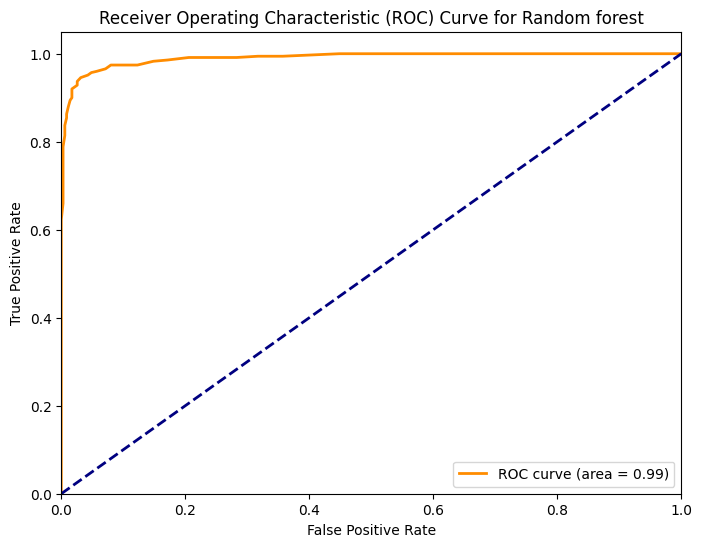

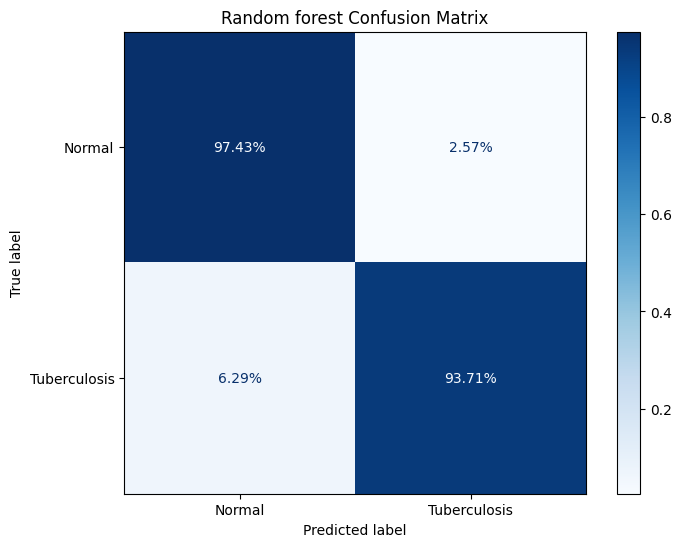

In [28]:
# classification report random forest
eval.report(test_labels,prediction_RF_text, "Random forest")
#AUC ROC for random forest
eval.plot_auc_roc_curve(RF_model, "Random forest", X_test, y_test)
# Confusion matrix random forest
eval.plot_confusion_matrix(test_labels, prediction_RF_text, "Random forest")

# Specificity for random forest
rf_specificity = eval.specificity(y_test,prediction_RF)*100


##### Support vector machine report


------Support Vector Machine model report------------
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97       350
Tuberculosis       0.98      0.96      0.97       350

    accuracy                           0.97       700
   macro avg       0.97      0.97      0.97       700
weighted avg       0.97      0.97      0.97       700



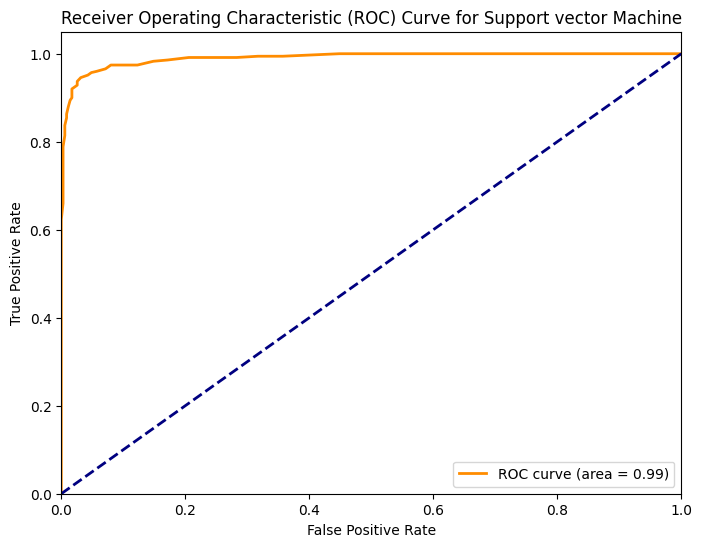

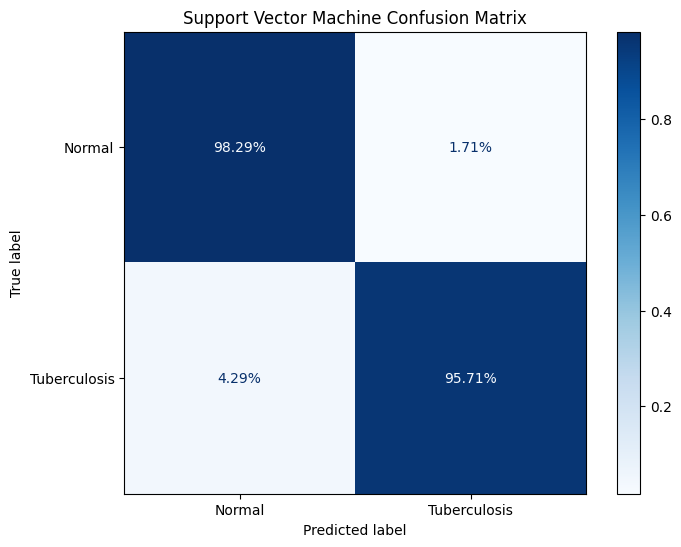

In [29]:
# classification report random forest
eval.report(test_labels,SVM_pred_text, "Support Vector Machine")
#AUC ROC for random forest
eval.plot_auc_roc_curve(RF_model, "Support vector Machine", X_test, y_test)
# Confusion matrix random forest
eval.plot_confusion_matrix(test_labels, SVM_pred_text, "Support Vector Machine")

# Specificity for random forest
svm_specificity = eval.specificity(y_test,prediction_RF)*100

#### LR Evaluation Report


------Linear Regression model report------------
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       350
Tuberculosis       1.00      0.98      0.99       350

    accuracy                           0.99       700
   macro avg       0.99      0.99      0.99       700
weighted avg       0.99      0.99      0.99       700



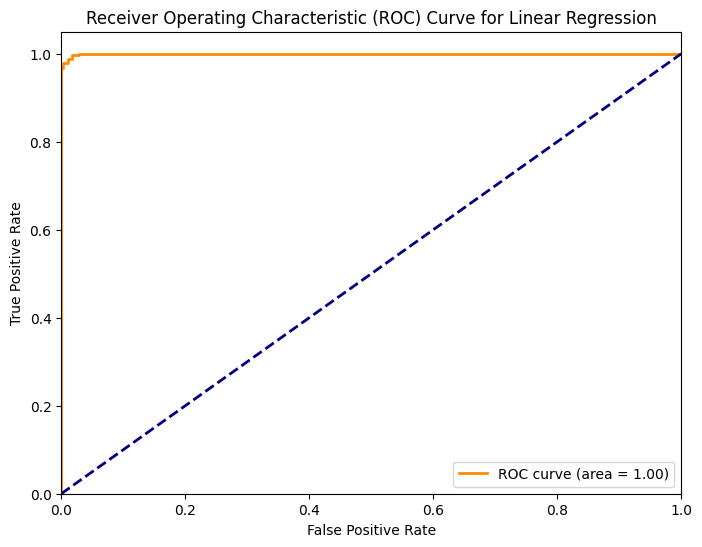

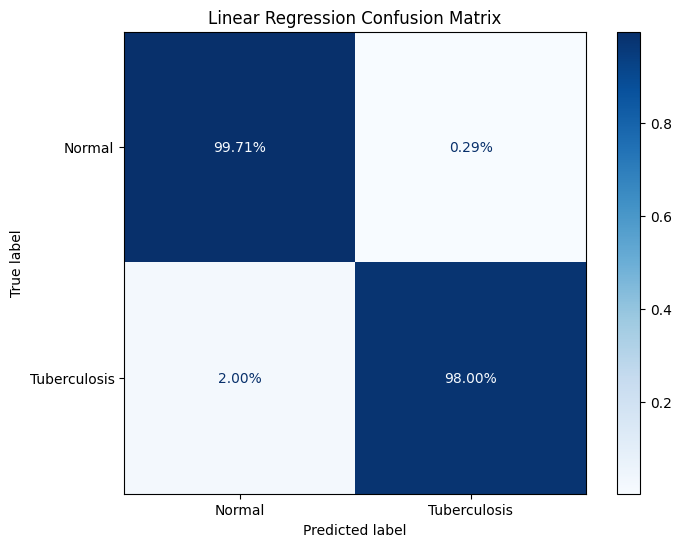

In [30]:
# classification report random forest
eval.report(test_labels,LR_pred_text, "Linear Regression")
#AUC ROC for random forest
eval.plot_auc_roc_curve(LR_Model, "Linear Regression", X_test, y_test)
# Confusion matrix random forest
eval.plot_confusion_matrix(test_labels,LR_pred_text, "Linear Regression")



# Specificity for random forest
LR_specificity = eval.specificity(y_test,LR_pred)*100

### Comparative Analysis of models


##### Model metrics


In [31]:
#Accuracy score for models
rf_accuracy,svm_accuracy,LR_accuracy = eval.model_accuracy(y_test,prediction_RF,SVM_pred,LR_pred)
#Precision score for the models
rf_precision,svm_precision,LR_precision = eval.model_precision(y_test,prediction_RF,SVM_pred,LR_pred)
#Sensitivity score for the models
rf_recall,svm_recall,LR_recall = eval.model_recall(y_test,prediction_RF,SVM_pred,LR_pred)
#F1_score for the models
rf_score,svm_score,LR_score = eval.model_f1_score(y_test,prediction_RF,SVM_pred,LR_pred)
#Specificity
rf_specificity = eval.specificity(y_test, prediction_RF)*100
svm_specificity = eval.specificity(y_test, SVM_pred)*100
LR_specificity = eval.specificity(y_test, LR_pred)*100

In [32]:
# Classification report for all models
models = {"Random forest": prediction_RF, "SVM": SVM_pred, "Linear Regression": LR_pred}
performance_metrics = {
    "Accuracy": (rf_accuracy, svm_accuracy, LR_accuracy),
    "Precision": (rf_precision, svm_precision, LR_precision),
    "Sensitivity": (rf_recall, svm_recall, LR_recall),
    "Specificity": (rf_specificity, svm_specificity, LR_specificity),
    "F1_score": (rf_score, svm_score, LR_score)
}

model_train_time = (rf_train_time, svm_train_time, NB_train_time)

#### Classification report for all models


In [33]:
from tabulate import tabulate

df_report = pd.DataFrame()
df_report = df_report.transpose()


df_report.index = models.keys()
# Add accuracy scores to the table
df_report['Accuracy'] = performance_metrics["Accuracy"]
# Add specificity scores to the table
df_report['Specificity'] = performance_metrics["Specificity"]
# Add precision scores to the table
df_report['Precision'] = performance_metrics["Precision"]
# Add recall scores to the table
df_report['Sensitivity'] = performance_metrics["Sensitivity"]
# Add f1_score scores to the table
df_report['f1_score'] = performance_metrics["F1_score"]
# Add model train time to the table
df_report['CPU_wall_time (ms)'] = model_train_time




# Convert values to percentages
df_report = df_report.map(lambda x: f"{x:.2f}")


# Display the table
print('Model Metrics')
print(tabulate(df_report, headers='keys', tablefmt='fancy_grid'))

Model Metrics
╒═══════════════════╤════════════╤═══════════════╤═════════════╤═══════════════╤════════════╤══════════════════════╕
│                   │   Accuracy │   Specificity │   Precision │   Sensitivity │   f1_score │   CPU_wall_time (ms) │
╞═══════════════════╪════════════╪═══════════════╪═════════════╪═══════════════╪════════════╪══════════════════════╡
│ Random forest     │         96 │            97 │          97 │            94 │         95 │                21.76 │
├───────────────────┼────────────┼───────────────┼─────────────┼───────────────┼────────────┼──────────────────────┤
│ SVM               │         97 │            98 │          98 │            96 │         97 │               311    │
├───────────────────┼────────────┼───────────────┼─────────────┼───────────────┼────────────┼──────────────────────┤
│ Linear Regression │         99 │           100 │         100 │            98 │         99 │                 0.45 │
╘═══════════════════╧════════════╧═══════════════╧

##### stacked Bar chart showing the performance for each model


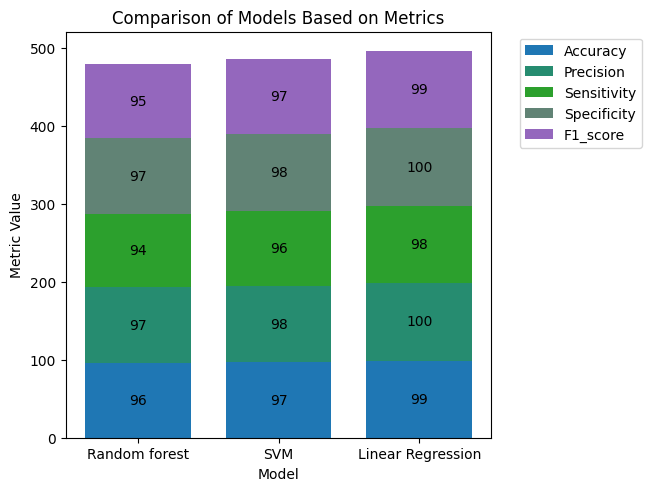

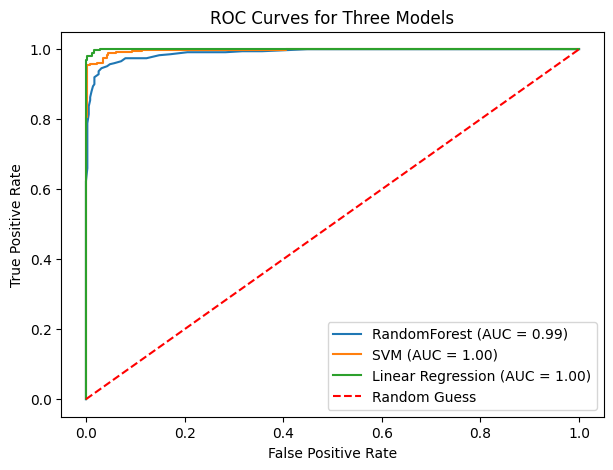

In [34]:
eval.sbar_chart(models.keys(), performance_metrics)
#ROC_AUC_CURVE
# Generate predictions

y_pred_proba_rf = RF_model.predict_proba(X_test)[:, 1]
y_pred_proba_svm = SVM_model.predict_proba(X_test)[:,1]
y_pred_proba_lr = LR_Model.predict_proba(X_test)[:, 1]


# Create a DataFrame
test_df = pd.DataFrame({'True': y_test,'RandomForest': y_pred_proba_rf, 'SVM': y_pred_proba_svm, 'Linear Regression': y_pred_proba_lr})



from sklearn.metrics import roc_curve, auc

# Plot ROC curve for each model
plt.figure(figsize=(7, 5))

for model in ['RandomForest', 'SVM', "Linear Regression"]:
  fpr, tpr, _ = roc_curve(test_df['True'], test_df[model])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Three Models')
plt.legend()
plt.show()


#### Save models


In [35]:
from joblib import dump, load
dump(RF_model,"RF_CLF.model")
dump(SVM_model,"SVM_CLF.model")
dump(LR_Model,"LR_CLF.model")

['LR_CLF.model']